In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
from sklearn.ensemble import RandomForestRegressor
sns.set()

import statsmodels.api as sm
%matplotlib inline

# 設定
import warnings
warnings.filterwarnings("ignore")

In [3]:
item=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/items.csv")
item_categories=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/item_categories.csv")
sales_train=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/sales_train.csv")
shops=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/shops.csv")
test_csv=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/test.csv")
sample_submission=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/sample_submission.csv")

In [5]:
# 日付カラムを正しくフォーマットする
sales_train.date=sales_train.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# 確認
print(sales_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [7]:
#agg()の引数に、適用したい処理を表す文字列や呼び出し可能オブジェクトのリストを指定
monthly_sales=sales_train.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})
monthly_sales.head()

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0

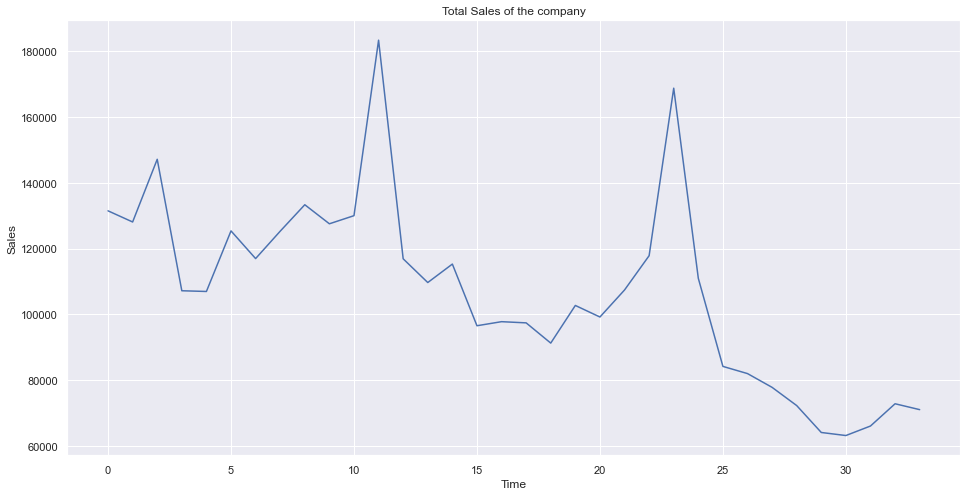

In [14]:
df=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()
df.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(df);

In [37]:
# 日付をインデックスとして時系列に追加する
df2=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()
df2.index=pd.date_range(start="2013-01",end="2015-10",freq="MS")
df2=df2.reset_index()
df2=df2.rename(columns={"index":"ds","item_cnt_day":"y"})
df2.head()

,ds,y
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [38]:
from fbprophet import Prophet
# prophetは以下の設定でpandas dfを必要とします。
# ( date column named as DS and the value column as Y)
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(df2) #fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [39]:
# predict for five months in the furure and MS - month start is the frequency
future=model.make_future_dataframe(periods=5,freq="MS")  
# now lets make the forecasts
forecast=model.predict(future)
forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83193.957233,80236.565913,86287.268653
35,2015-12-01,125513.062914,122371.714197,128788.040852
36,2016-01-01,75625.688515,72472.500445,78748.615596
37,2016-02-01,40109.144414,37028.851146,43197.217964
38,2016-03-01,76664.084640,73472.294349,79680.166290


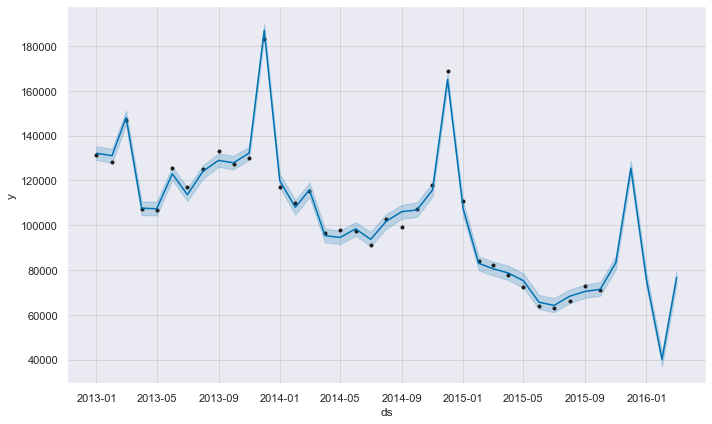

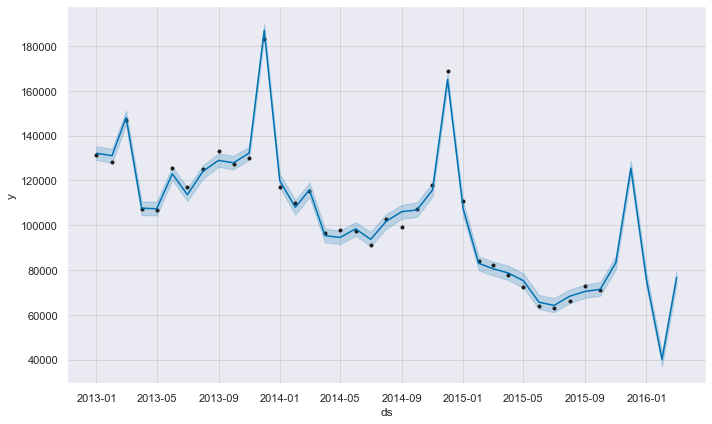

In [40]:
model.plot(forecast)